In [99]:
import pickle
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
splits = ['random', 'scaffold', 'protein']
datasets = ['pdbbind', 'platinum']
tasks = ['all', 'easy', 'hard']
results_dir = 'results/'
iterations = range(5)

In [101]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()

In [102]:
for split in splits :

    for iteration in iterations :
        
        for dataset in datasets :
            
            experiment_name = f'{split}_split_{iteration}'
            evaluation_name = f'{experiment_name}_{dataset}'
            
            working_dir = os.path.join(results_dir, evaluation_name)
            for task in tasks :
                dataset_results_path = os.path.join(working_dir, f'dataset_results_{task}.p')
                with open(dataset_results_path, 'rb') as f:
                    dataset_results = pickle.load(f)

                dataset_results['bioactive_accuracy']['split'] = split
                dataset_results['bioactive_accuracy']['dataset'] = dataset
                dataset_results['bioactive_accuracy']['task'] = task
                bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy']), ignore_index=True)

                for average_type in dataset_results['regression'] :
                    dataset_results['regression'][average_type]['split'] = split
                    dataset_results['regression'][average_type]['dataset'] = dataset
                    dataset_results['regression'][average_type]['task'] = task
                    dataset_results['regression'][average_type]['average_type'] = average_type
                    regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

                for ranker in dataset_results['ranking'] :
                    dataset_results['ranking'][ranker]['split'] = split
                    dataset_results['ranking'][ranker]['dataset'] = dataset
                    dataset_results['ranking'][ranker]['task'] = task
                    dataset_results['ranking'][ranker]['ranker'] = ranker
                    ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

In [103]:
correct_dataset_name = {
    'pdbbind' : 'PDBBind',
    'platinum' : 'Platinum'
}

# Regression

In [6]:
regression_df['subset'] = regression_df['task']

In [7]:
regression_df.head()

,average_type,dataset,pearson_all,pearson_gen,r2_all,r2_gen,rmse_all,rmse_bio,rmse_gen,spearman_all,spearman_gen,split,task,subset
0,Micro,pdbbind,0.775477,0.638807,0.589096,0.343004,0.632961,0.842588,0.776545,0.761224,0.619813,random,all,all
1,Macro,pdbbind,0.379780,0.344565,-2.340023,-2.860052,0.530981,1.087371,0.508041,0.346400,0.323887,random,all,all
2,Micro,pdbbind,0.658180,0.550155,0.381969,0.156774,0.537294,0.581175,0.583859,0.601741,0.445911,random,easy,easy
3,Macro,pdbbind,0.293127,0.227265,-6.316238,-7.468204,0.447707,0.750353,0.410589,0.262645,0.203122,random,easy,easy
4,Micro,pdbbind,0.761534,0.612223,0.564484,0.298477,0.644391,0.986251,0.797251,0.747489,0.591355,random,hard,hard


In [163]:
def r2_results(dataset) :
    ylabel = 'R2'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'r2_all']]
    all_data = all_data.rename({'r2_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'r2_gen']]
    gen_data = gen_data.rename({'r2_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    merged_data = pd.concat([all_data, gen_data])

    grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({ylabel : ['mean', 'std']})
    grouped_data.round(2)
    
    return grouped_data

In [164]:
grouped_data = r2_results('pdbbind')
grouped_data.round(2)

R2      
                              mean   std
Conformation subset split               
All                 random    0.59  0.02
                    scaffold  0.48  0.02
                    protein   0.45  0.03
Generated           random    0.33  0.03
                    scaffold  0.29  0.03
                    protein   0.34  0.03

In [165]:
grouped_data = r2_results('platinum')
grouped_data.round(2)

R2      
                              mean   std
Conformation subset split               
All                 random    0.37  0.06
                    scaffold  0.38  0.03
                    protein   0.33  0.08
Generated           random    0.13  0.06
                    scaffold  0.18  0.01
                    protein   0.14  0.06

In [166]:
def rmse_results(dataset) : 
    ylabel = 'Mean RMSE'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'rmse_all']]
    all_data = all_data.rename({'rmse_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'rmse_gen']]
    gen_data = gen_data.rename({'rmse_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    bio_data = new_data[['split', 'rmse_bio']]
    bio_data = bio_data.rename({'rmse_bio' : ylabel}, axis=1)
    bio_data['Conformation subset'] = 'Bioactive'
    merged_data = pd.concat([all_data, gen_data, bio_data])

    grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({ylabel : ['mean', 'std']})
    return grouped_data

In [167]:
grouped_data = rmse_results('pdbbind')
grouped_data.round(2)

Mean RMSE      
                                  mean   std
Conformation subset split                   
All                 random        0.62  0.01
                    scaffold      0.68  0.02
                    protein       0.71  0.04
Generated           random        0.77  0.01
                    scaffold      0.77  0.02
                    protein       0.76  0.03
Bioactive           random        0.90  0.06
                    scaffold      1.41  0.08
                    protein       1.36  0.09

In [168]:
grouped_data = rmse_results('platinum')
grouped_data.round(2)

Mean RMSE      
                                  mean   std
Conformation subset split                   
All                 random        0.65  0.03
                    scaffold      0.65  0.01
                    protein       0.67  0.04
Generated           random        0.74  0.03
                    scaffold      0.71  0.01
                    protein       0.73  0.03
Bioactive           random        1.12  0.05
                    scaffold      1.26  0.08
                    protein       1.15  0.08

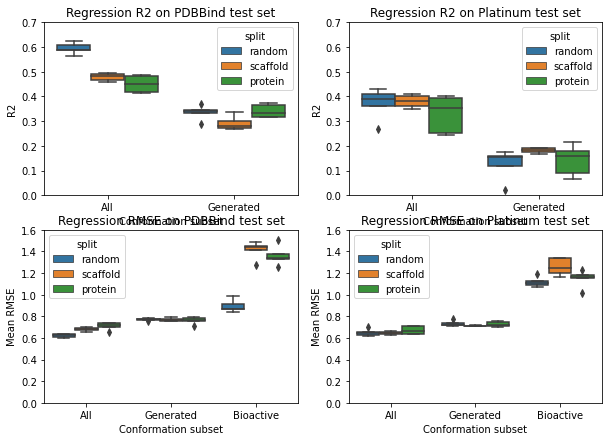

In [170]:
f, axes = plt.subplots(2, 2, figsize=(10,7))
for i, dataset in enumerate(datasets) :
    ylabel = 'R2'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'r2_all']]
    all_data = all_data.rename({'r2_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'r2_gen']]
    gen_data = gen_data.rename({'r2_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    merged_data = pd.concat([all_data, gen_data])

    ax = axes[0][i]
    sns.boxplot(data=merged_data, x='Conformation subset', y=ylabel, hue='split', ax=ax)
    dataset_name = correct_dataset_name[dataset]
    ax.set_title(f'Regression R2 on {dataset_name} test set')
    ax.set_ylim(0, 0.7)
    
    ylabel = 'Mean RMSE'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'rmse_all']]
    all_data = all_data.rename({'rmse_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'rmse_gen']]
    gen_data = gen_data.rename({'rmse_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    bio_data = new_data[['split', 'rmse_bio']]
    bio_data = bio_data.rename({'rmse_bio' : ylabel}, axis=1)
    bio_data['Conformation subset'] = 'Bioactive'
    merged_data = pd.concat([all_data, gen_data, bio_data])

    ax = axes[1][i]
    sns.boxplot(data=merged_data, x='Conformation subset', y=ylabel, hue='split', ax=ax)
    dataset_name = correct_dataset_name[dataset]
    ax.set_title(f'Regression RMSE on {dataset_name} test set')
    ax.set_ylim(0, 1.6)

In [171]:
f.tight_layout()

In [172]:
f.savefig(f'figures/regression.png', dpi=300)

# Bioactive conformation identification

In [152]:
bioactive_accuracy_df['subset'] = bioactive_accuracy_df['task']

In [153]:
bioactive_accuracy_df.head()

,dataset,mean_top1_accuracy,mean_topN_accuracy,median_all_bioactive,median_min_bioactive,median_normalized_bioactive,q1_all_bioactive,q1_min_bioactive,q1_normalized_bioactive,q3_all_bioactive,q3_min_bioactive,q3_normalized_bioactive,split,task,subset
0,pdbbind,0.389171,0.374401,4.0,2.0,0.068796,0.0,0.0,0.0,15.00,20.00,0.363636,random,all,all
1,pdbbind,0.364796,0.354728,3.0,2.0,0.138095,1.0,0.0,0.0,8.00,7.00,0.461742,random,easy,easy
2,pdbbind,0.401266,0.384163,4.0,4.0,0.039604,0.0,0.0,0.0,22.75,31.75,0.314356,random,hard,hard
3,platinum,0.261711,0.263243,7.0,6.0,0.148515,1.0,0.0,0.0,28.00,28.00,0.441176,random,all,all
4,platinum,0.290058,0.299467,3.0,2.0,0.198765,1.0,0.0,0.0,9.00,8.00,0.486947,random,easy,easy


In [148]:
def bioactive_ratio_results(dataset) :
    ylabel = 'Ratio of molecules with bioactive ranked first'
    new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                             & (bioactive_accuracy_df['task'] == 'all')]
    new_data = new_data.rename({'mean_top1_accuracy' : ylabel}, axis=1)
    
    grouped_data = new_data.groupby(['split'], sort=False).agg({ylabel : ['mean', 'std']})
    return grouped_data

In [154]:
def bioactive_rank_results(dataset) :
    ylabel = 'Median normalized rank of bioactive conformation'
    new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                             & (bioactive_accuracy_df['task'] == 'all')]
    new_data = new_data.rename({'median_normalized_bioactive' : ylabel}, axis=1)

    grouped_data = new_data.groupby(['split'], sort=False).agg({ylabel : ['mean', 'std']})
    return grouped_data

In [155]:
grouped_data = bioactive_ratio_results('pdbbind')
grouped_data.round(2)

Ratio of molecules with bioactive ranked first      
                                                   mean   std
split                                                        
random                                             0.38  0.02
scaffold                                           0.24  0.01
protein                                            0.20  0.02

In [156]:
grouped_data = bioactive_ratio_results('platinum')
grouped_data.round(2)

Ratio of molecules with bioactive ranked first      
                                                   mean   std
split                                                        
random                                             0.27  0.02
scaffold                                           0.22  0.01
protein                                            0.21  0.02

In [157]:
grouped_data = bioactive_rank_results('pdbbind')
grouped_data.round(2)

Median normalized rank of bioactive conformation      
                                                     mean   std
split                                                          
random                                               0.06  0.02
scaffold                                             0.16  0.02
protein                                              0.23  0.02

In [158]:
grouped_data = bioactive_rank_results('platinum')
grouped_data.round(2)

Median normalized rank of bioactive conformation      
                                                     mean   std
split                                                          
random                                               0.14  0.02
scaffold                                             0.19  0.01
protein                                              0.20  0.02

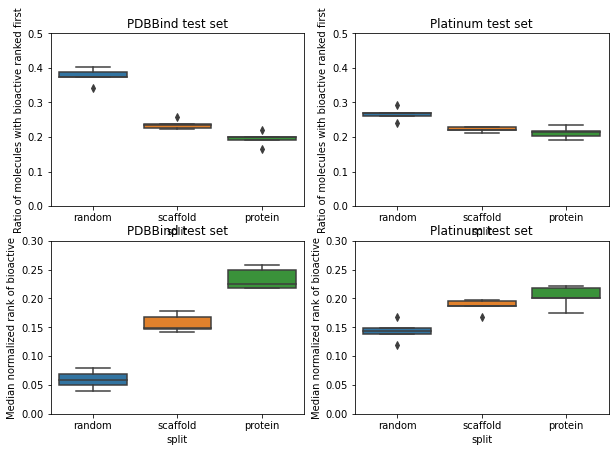

In [18]:
f, axes = plt.subplots(2, 2, figsize=(10,7))

for i, dataset in enumerate(datasets) :
    dataset_name = correct_dataset_name[dataset]
    
    ylabel = 'Ratio of molecules with bioactive ranked first'
    new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                             & (bioactive_accuracy_df['task'] == 'all')]
    new_data = new_data.rename({'mean_top1_accuracy' : ylabel}, axis=1)
    
    ax = axes[0][i]
    sns.boxplot(data=new_data, x='split', y=ylabel, ax=ax)
    ax.set_title(f'{dataset_name} test set')
    ax.set_ylim(0, 0.5)
#     plt.savefig(f'figures/mean_bioactive_accuracy_{dataset}.png', dpi=200)
#     plt.show()

    grouped_data = new_data.groupby(['split'], sort=False).agg({ylabel : ['mean', 'std']})
    grouped_data.round(2)
    
    ylabel = 'Median normalized rank of bioactive'
    new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                             & (bioactive_accuracy_df['task'] == 'all')]
    new_data = new_data.rename({'median_relative_bioactive' : ylabel}, axis=1)

    ax = axes[1][i]
    sns.boxplot(data=new_data, x='split', y=ylabel, ax=ax)
    ax.set_title(f'{dataset_name} test set')
    ax.set_ylim(0, 0.3)
    #plt.savefig(f'figures/median_min_bioactive_{dataset}.png', dpi=200)
    #plt.show()

    grouped_data = new_data.groupby(['split'], sort=False).agg({ylabel : ['mean', 'std']})
    grouped_data.round(2)

In [19]:
f.tight_layout()

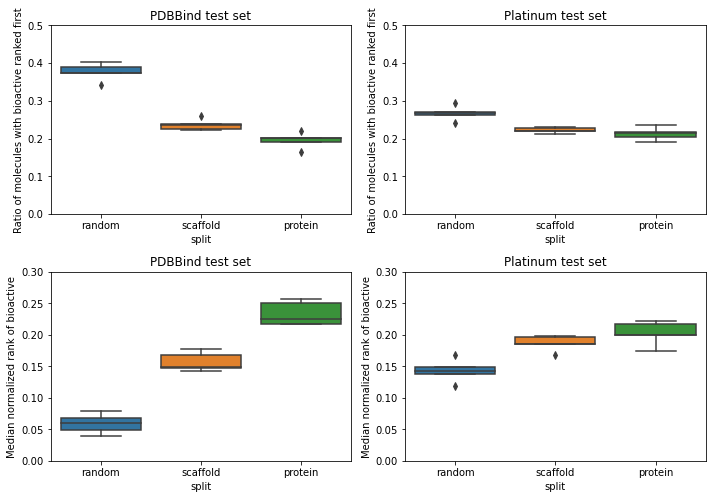

In [20]:
f

In [21]:
f.savefig(f'figures/bioactive_identification.png', dpi=300)

# Ranking

In [22]:
ranking_df['subset'] = ranking_df['task']

In [23]:
ranking_df.head()

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,ef_0.95,ef_0.96,ef_0.97,ef_0.98,ef_0.99,ef_1.0,ranker,split,task,subset
0,0.108791,pdbbind,0.984479,0.890522,0.937042,0.908274,0.938881,0.954952,0.978417,0.975969,...,0.999738,1.000096,1.000861,1.000313,0.999603,1.0,random,random,all,all
1,0.152912,pdbbind,1.462954,1.493061,1.464282,1.462949,1.419113,1.412058,1.386389,1.375987,...,1.008360,1.007255,1.005781,1.003203,1.001191,1.0,energy,random,all,all
2,0.160838,pdbbind,1.680284,1.557031,1.585464,1.521339,1.478691,1.454785,1.446389,1.431588,...,1.002258,0.999539,0.999176,0.998643,0.999405,1.0,ccdc,random,all,all
3,0.295405,pdbbind,3.083097,2.998997,2.930990,2.843547,2.839814,2.783377,2.727885,2.696067,...,1.026122,1.020700,1.014548,1.009034,1.004564,1.0,model,random,all,all
4,0.083039,pdbbind,0.667540,0.642768,0.616558,0.678169,0.718339,0.835414,0.832364,0.821430,...,0.996520,0.999971,1.001582,1.000055,1.000000,1.0,random,random,easy,easy


In [160]:
def ef_01_results(dataset) :
    ylabel = 'Mean enrichment factor at fraction 0.1'
    new_data = ranking_df[(ranking_df['dataset'] == dataset) 
                             & (ranking_df['task'] == 'all')]
    new_data = new_data.rename({'ef_0.1' : ylabel}, axis=1)

    grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ylabel : ['mean', 'std']})
    return grouped_data

In [161]:
grouped_data = ef_01_results('pdbbind')
grouped_data.round(2)

Mean enrichment factor at fraction 0.1      
                                                  mean   std
split    ranker                                             
random   random                                   1.00  0.03
         energy                                   1.37  0.08
         ccdc                                     1.43  0.07
         model                                    2.59  0.11
scaffold random                                   1.03  0.02
         energy                                   1.37  0.10
         ccdc                                     1.36  0.03
         model                                    1.95  0.10
protein  random                                   0.96  0.02
         energy                                   1.45  0.05
         ccdc                                     1.49  0.05
         model                                    1.73  0.13

In [162]:
grouped_data = ef_01_results('platinum')
grouped_data.round(2)

Mean enrichment factor at fraction 0.1      
                                                  mean   std
split    ranker                                             
random   random                                   1.00  0.01
         energy                                   1.48  0.00
         ccdc                                     1.57  0.00
         model                                    2.08  0.06
scaffold random                                   1.00  0.02
         energy                                   1.48  0.00
         ccdc                                     1.57  0.00
         model                                    1.89  0.05
protein  random                                   1.00  0.01
         energy                                   1.48  0.00
         ccdc                                     1.57  0.00
         model                                    1.86  0.12

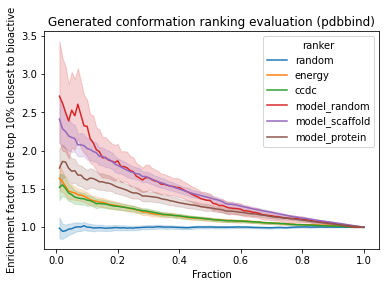

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


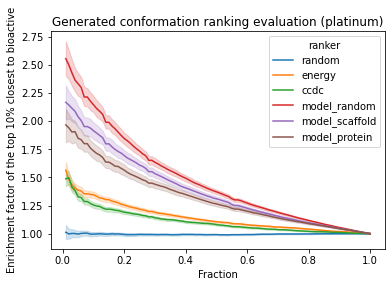

In [25]:
for dataset in datasets :
    df = pd.DataFrame()
    for split in splits :
        evaluation_name = f'{split}_split_0_{dataset}'
        ef_df_path = os.path.join('results/',
                                 evaluation_name,
                                 'ef_df.csv')
        ef_df = pd.read_csv(ef_df_path, index_col=0)
        ef_df['ranker'] = ef_df['ranker'].replace({'model' : f'model_{split}'})
        df = df.append(ef_df, ignore_index=True)
    df = df.rename({'Enrichment factor' : 'Enrichment factor of the top 10% closest to bioactive'}, axis=1)

    sns.lineplot(data=df, x='Fraction', y=f'Enrichment factor of the top 10% closest to bioactive', hue='ranker')
    plt.title(f'Generated conformation ranking evaluation ({dataset})')
    fig_path = os.path.join('figures/', 
                            f'efs_{dataset}.png')
    plt.savefig(fig_path, dpi=300)
    plt.show()

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


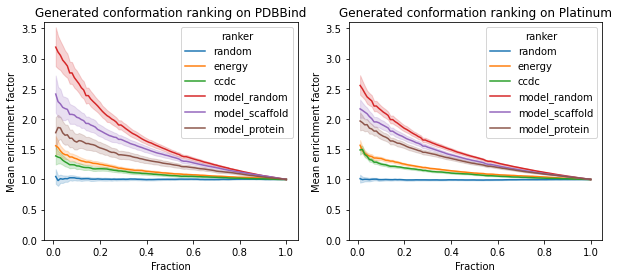

In [185]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, dataset in enumerate(datasets) :
    ylabel = 'Mean enrichment factor'
    dataset_name = correct_dataset_name[dataset]
    df = pd.DataFrame()
    for split in splits :
        evaluation_name = f'{split}_split_0_{dataset}'
        ef_df_path = os.path.join('results/',
                                 evaluation_name,
                                 'ef_df.csv')
        ef_df = pd.read_csv(ef_df_path, index_col=0)
        ef_df['ranker'] = ef_df['ranker'].replace({'model' : f'model_{split}'})
        df = df.append(ef_df, ignore_index=True)
    df = df.rename({'Enrichment factor' : ylabel}, axis=1)

    ax = axes[i]
    sns.lineplot(data=df, x='Fraction', y=ylabel, hue='ranker', ax=ax)
    ax.set_title(f'Generated conformation ranking on {dataset_name}')
    ax.set_ylim(0, 3.6)

In [186]:
f.tight_layout()

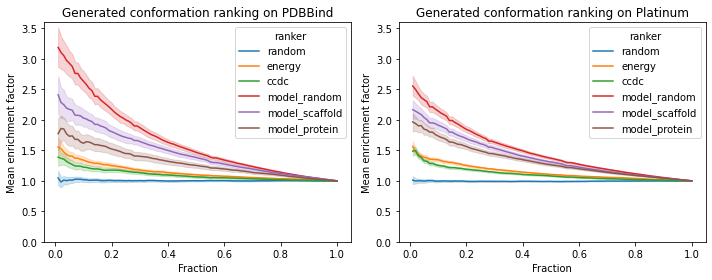

In [187]:
f

In [188]:
f.savefig(f'figures/efs.png', dpi=300)

# Rigid ligand docking

In [72]:
df = pd.DataFrame()
for split in splits :
    evaluation_name = f'{split}_split_0_v2_pdbbind'
    recall_df_path = os.path.join('results/',
                             evaluation_name,
                             'rigid_ligand_docking_recall_successful_only.csv')
    recall_df = pd.read_csv(recall_df_path, index_col=0)
    recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
    df = df.append(recall_df, ignore_index=True)

In [74]:
df['Number of input conformations'] = df['Number of input conformations'] + 1

In [76]:
df[(df['Number of input conformations'] == 20) & (df['metric'] == 'ligand_rmsd')].groupby('ranker').agg({'Recall' : ['mean', 'std']})

Recall          
                    mean       std
ranker                            
CCDC            0.262278  0.016340
energy          0.316484  0.007794
model_protein   0.332944       NaN
model_random    0.577412       NaN
model_scaffold  0.402421       NaN
random          0.206594  0.022923
score           0.773970  0.004849

In [77]:
df['metric'].unique()

array(['score', 'ligand_rmsd', 'overlay_rmsd', 'docking_power',
       'correct_conf'], dtype=object)

In [78]:
metric = 'ligand_rmsd'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of closest conformation to bioactive'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking.png')
plt.savefig(fig_path, dpi=300)
plt.close()

In [79]:
metric = 'ligand_rmsd'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of closest conformation to bioactive'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
plt.xlim(0, 20)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking_truncated.png')
plt.savefig(fig_path, dpi=300)
plt.close()

In [80]:
flexible_docking_powers = {
    'random' : 0.68,
    'scaffold' : 0.57,
    'protein' : 0.63
}

generation_powers = {
    'random' : 0.76,
    'scaffold' : 0.70,
    'protein' : 0.79
}

In [90]:
splits = ['random', 'scaffold', 'protein']
df = pd.DataFrame()
for split in splits :
    evaluation_name = f'{split}_split_0_v2_pdbbind'
    recall_df_path = os.path.join('results/',
                             evaluation_name,
                             'rigid_ligand_docking_recall_all.csv')
    recall_df = pd.read_csv(recall_df_path, index_col=0)
    recall_df['Number of input conformations'] = recall_df['Number of input conformations'] + 1
    recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
    flexible_docking_power = flexible_docking_powers[split]
    print(recall_df[(recall_df['Recall'] >= flexible_docking_power) 
              & (recall_df['metric'] == 'docking_power')].drop_duplicates(subset='ranker'))
    df = df.append(recall_df, ignore_index=True)

      Number of input conformations    Recall         metric        ranker
1512                             13  0.681001  docking_power  model_random
1633                             34  0.681001  docking_power        energy
1706                              7  0.685494  docking_power         score
1826                             27  0.684852  docking_power        random
1938                             39  0.681001  docking_power          CCDC
      Number of input conformations    Recall         metric          ranker
1508                              9  0.586035  docking_power  model_scaffold
1613                             14  0.576060  docking_power          energy
1701                              2  0.623441  docking_power           score
1810                             11  0.581047  docking_power          random
1912                             13  0.574813  docking_power            CCDC
      Number of input conformations    Recall         metric         ranker
1514        

In [91]:
df[(df['Number of input conformations'] == 100) & (df['metric'] == 'docking_power')].groupby('ranker').agg({'Recall' : ['mean', 'std']})

Recall          
                    mean       std
ranker                            
CCDC            0.815619  0.014264
energy          0.815619  0.014264
model_protein   0.825397       NaN
model_random    0.822208       NaN
model_scaffold  0.799252       NaN
random          0.815619  0.014264
score           0.815619  0.014264

In [98]:
# Docking power 60%
df[(df['Recall'] >= 0.60) & (df['metric'] == 'docking_power')].drop_duplicates(subset='ranker')# .groupby('ranker').agg({'Conformation rank' : ['mean', 'std']})

,Number of input conformations,Recall,metric,ranker
1506,7,0.603338,docking_power,model_random
1621,22,0.605905,docking_power,energy
1702,3,0.618742,docking_power,score
1815,16,0.605263,docking_power,random
1919,20,0.602696,docking_power,CCDC
4009,10,0.604738,docking_power,model_scaffold
6511,12,0.608135,docking_power,model_protein


In [96]:
metric = 'docking_power'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of closest conformation to bioactive'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
plt.ylim(0,1)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking.png')
plt.savefig(fig_path, dpi=300)
plt.close()

In [97]:
metric = 'docking_power'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of closest conformation to bioactive'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
plt.xlim(0, 20)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking_trucated.png')
plt.savefig(fig_path, dpi=300)
plt.close()